In [1]:
import sys
import numpy as np
from datascience import *
import math 
# These lines set up the plotting functionality and formatting.
import matplotlib
matplotlib.use('Agg', warn=False)
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
#this cell sets up measures of inflation by year, quarter, and month
cpiY = Table().read_table("CPI.csv").relabeled(1, "CPI")
cpiYs = cpiY.column("CPI")
piY = np.diff(cpiYs)/(cpiYs[:len(cpiYs) - 1])

cpiQ = Table().read_table("quarterlyCPI.csv").relabeled(1, "CPI")
cpiQs = cpiQ.column("CPI")
piQ = np.diff(cpiQs)/(cpiQs[:len(cpiQs) - 1])

cpiM = Table().read_table("monthlyCPI.csv").relabeled(1, "CPI")
cpiMs = cpiM.column("CPI")
piM = np.diff(cpiMs)/(cpiMs[:len(cpiMs) - 1])

inflation_by_year = Table().with_columns("DATE", np.arange(1947, 2016), "INFLATION RATE", piY)
inflation_by_quarter = Table().with_columns("DATE", cpiQ.column(0)[:len(piQ)], "INFLATION RATE", piQ)
inflation_by_month = Table().with_columns("DATE", cpiM.column(0)[:len(piM)], "INFLATION RATE", piM)
inflation_by_month = inflation_by_month.with_column("DATE", [x[:len(x) - 3] for x in inflation_by_month.column("DATE")]).where("INFLATION RATE", are.between(-.01, .02))

In [3]:
#this cell sets up the rest of the data
r = Table().read_table("r*.csv").select("TIME", "Value").relabeled("TIME", "DATE").relabeled("Value", "r")

unemployment = Table().read_table("unemployment.csv").relabeled(1, "UNEMPLOYMENT RATE")

y_pop = Table().read_table("Y*.csv").relabeled(1, "POTENTIAL GDP")

y = Table().read_table("Y.csv").relabeled(1, "GDP")

gdp = y.join("DATE", y_pop)

distress = Table().read_table("distress.csv").relabeled(1, "ECONOMIC CONDITION")
new_distress = []
for num in distress.column(1):
    if num < 60:
        new_distress.append("Emergency")
    elif num < 70:
        new_distress.append("Distressed")
    elif num < 80:
        new_distress.append("At-Risk")
    elif num < 60:
        new_distress.append("Good")
    else:
        new_distress.append("Excellent")
distress = distress.with_column("ECONOMIC CONDITION", new_distress)

## Quarterly Data from 1949 to Present

The table below contains real GDP, real potential GDP, unemployment rate, inflation rate, and level below potential per quarter.
GDP is defined as the market value of the final goods and services newly produced in a country during some period of time, adjusted for price changes. Potential GDP is this measure of output given by long-run economic variables such as capital, technology, amd employment at normal economic times (not in a recession/boom).

In [4]:
quarterly_data = gdp.join("DATE", unemployment).join("DATE", inflation_by_quarter)
quarterly_data = quarterly_data.with_column("OUTPUT MINUS POTENTIAL", quarterly_data.column(1) - quarterly_data.column(2)).with_column("DATE", [x[:len(x) - 3] for x in quarterly_data.column(0)])
quarterly_data

DATE,GDP,POTENTIAL GDP,UNEMPLOYMENT RATE,INFLATION RATE,OUTPUT MINUS POTENTIAL
1949-01,2007.5,2011.3,4.3,-0.00108591,-3.8
1949-04,2000.8,2038.1,5.3,-0.00836225,-37.3
1949-07,2022.8,2065.2,6.7,-0.00240334,-42.4
1949-10,2004.7,2092.6,7.9,-0.00308538,-87.9
1950-01,2084.6,2120.1,6.5,0.00763132,-35.5
1950-04,2147.6,2147.2,5.8,0.0183448,0.4
1950-07,2230.4,2174.7,5,0.0202454,55.7
1950-10,2273.4,2202.5,4.2,0.0406593,70.9
1951-01,2304.5,2230.8,3.7,0.00972876,73.7
1951-04,2344.5,2260.7,3.1,-0.000539561,83.8


** The economy is in a recession when real GDP (output adjusted for inflation) is below the economy's potential. We can see this effect below. **

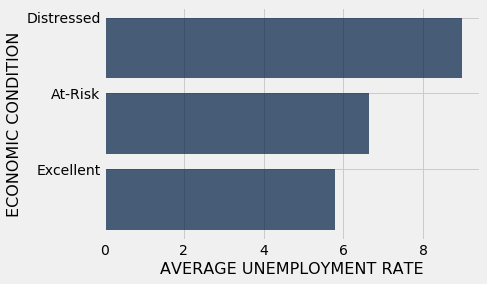

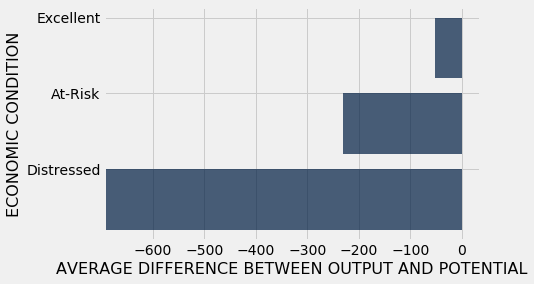

In [5]:
distress = distress.with_column("DATE", [x[:len(x) - 3] for x in distress.column("DATE")]).join("DATE", quarterly_data)
distress.group("ECONOMIC CONDITION", np.mean).relabeled("UNEMPLOYMENT RATE mean", "AVERAGE UNEMPLOYMENT RATE").sort("AVERAGE UNEMPLOYMENT RATE", descending = True).barh("ECONOMIC CONDITION", "AVERAGE UNEMPLOYMENT RATE")
distress.group("ECONOMIC CONDITION", np.mean).sort("OUTPUT MINUS POTENTIAL mean", descending = True).relabeled("OUTPUT MINUS POTENTIAL mean", "AVERAGE DIFFERENCE BETWEEN OUTPUT AND POTENTIAL").barh("ECONOMIC CONDITION", "AVERAGE DIFFERENCE BETWEEN OUTPUT AND POTENTIAL")

## The Great Recession

** Now we know that when output falls below potential, the economy is in worse shape (a condition reinforced by unemployment rate). We can see the U.S. economy's condition over time changing between 2000 and 2018 below.**

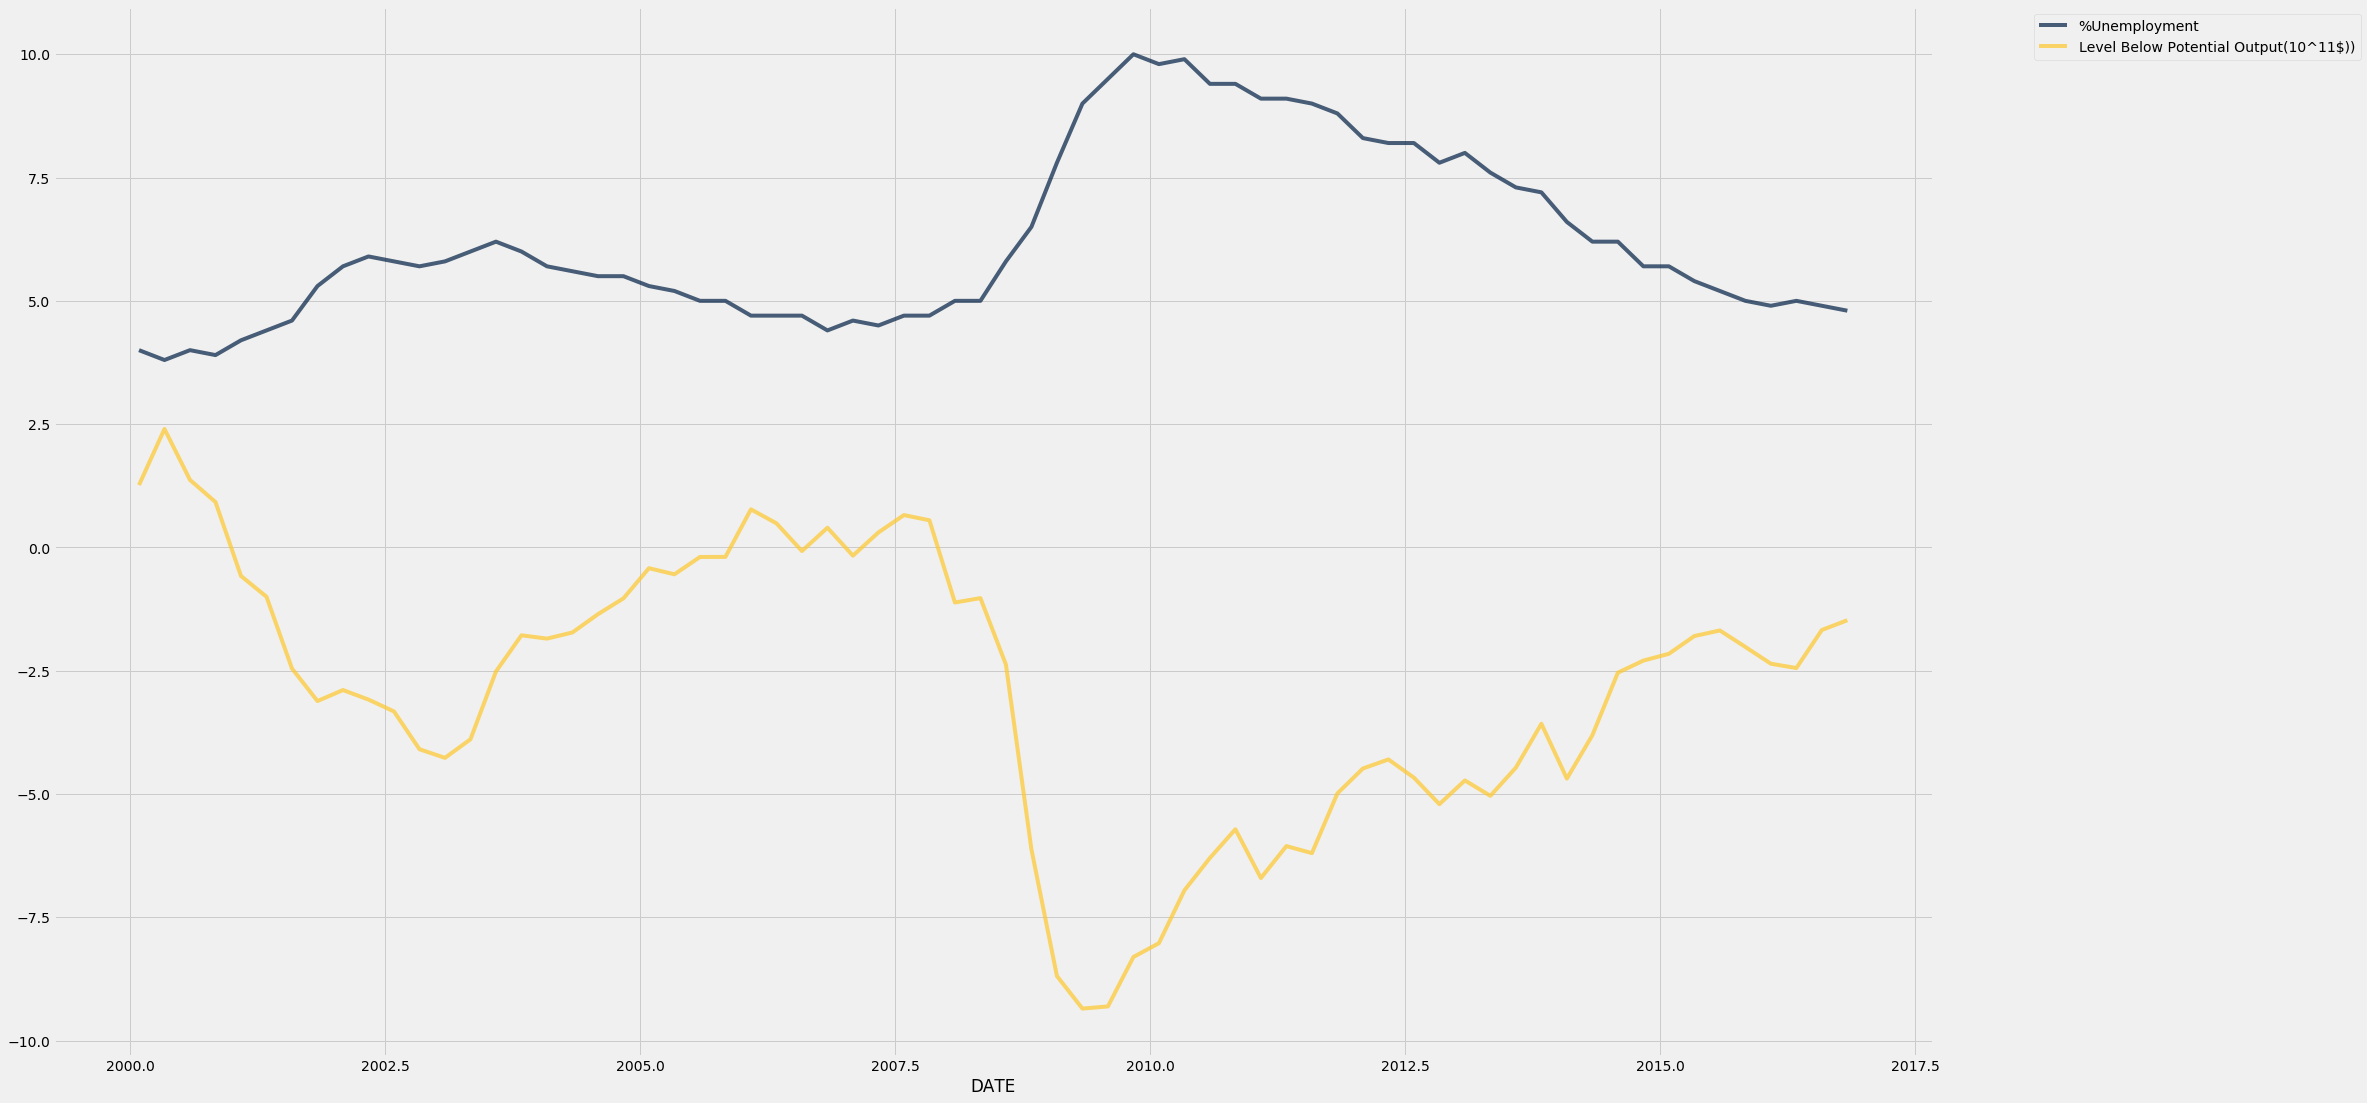

In [6]:
quarterly_w_time = quarterly_data.select("UNEMPLOYMENT RATE", "OUTPUT MINUS POTENTIAL").with_column("DATE", [int(x[:len(x) - 3]) + int(x[len(x) - 2:])/12 for x in quarterly_data.column("DATE")])
recession_line_data = quarterly_w_time.with_column("OUTPUT MINUS POTENTIAL", quarterly_w_time.column("OUTPUT MINUS POTENTIAL") / 100).relabeled("UNEMPLOYMENT RATE", "%Unemployment").relabeled("OUTPUT MINUS POTENTIAL", "Level Below Potential Output(10^11$))")
recession_line_data = recession_line_data.where("DATE", are.between(2000, 2018))
recession_line_data.plot("DATE", width = 30, height = 18)

**Perumutation Test**
Run a permutation test on output - potential vs economic condition



In [7]:
"""
A list of recessions in the U.S. as per 
https://en.wikipedia.org/wiki/List_of_recessions_in_the_United_States

Each entry is of the format ((Year Start, Month Start), (Year End, Month End))
"""
recession_list = [((1948, 11),(1949,10)), ((1953, 7),(1954,5)), 
                  ((1957, 8),(1958,4)), ((1960, 4),(1961,2)),
                  ((1969, 12),(1970,11)), ((1973, 11),(1975,3)),
                  ((1980, 1),(1980,7)), ((1981, 7),(1982,11)),
                  ((1990, 7),(1991,3)), ((2001, 3),(2001,11)),
                  ((2007, 12),(2009,6))
                 ]

def isRecession(date):
    """Given a date of str format 'Year-Month'
    determines if the date is within a span of a recession
    
    Implemented using binary search
    """
    dateInt = int(date[0:4])*100 + int(date[5:])
    left, right=  0, len(recession_list)-1
    while(left <= right):
        mid = (right+left)//2
        testRange = recession_list[mid]
        leftInt = testRange[0][0]*100 + testRange[0][1]
        rightInt = testRange[1][0]*100 + testRange[1][1]
        if(dateInt >= leftInt and dateInt <= rightInt):
            return True
        if(dateInt < leftInt):
            right = mid-1
        else:
            left = mid+1
    return False
    

quarterly_data_rec = quarterly_data.with_column("In Recession", quarterly_data.apply(isRecession, 'DATE'))
quarterly_data_rec

DATE,GDP,POTENTIAL GDP,UNEMPLOYMENT RATE,INFLATION RATE,OUTPUT MINUS POTENTIAL,In Recession
1949-01,2007.5,2011.3,4.3,-0.00108591,-3.8,True
1949-04,2000.8,2038.1,5.3,-0.00836225,-37.3,True
1949-07,2022.8,2065.2,6.7,-0.00240334,-42.4,True
1949-10,2004.7,2092.6,7.9,-0.00308538,-87.9,True
1950-01,2084.6,2120.1,6.5,0.00763132,-35.5,False
1950-04,2147.6,2147.2,5.8,0.0183448,0.4,False
1950-07,2230.4,2174.7,5,0.0202454,55.7,False
1950-10,2273.4,2202.5,4.2,0.0406593,70.9,False
1951-01,2304.5,2230.8,3.7,0.00972876,73.7,False
1951-04,2344.5,2260.7,3.1,-0.000539561,83.8,False


** Null Hypothesis: ** In the population, whether the economy is in a recession and output level relative to potential output are independent of each other. The average output minus potential is inherently the same regardless; the low level during the Great Recession is only due to chance.

** Alternative Hypothesis: ** The two distributions (recessionary, non-recessionary) are different in the population.

** Significance Level: ** $\alpha = .05$

** Test Statistic: ** Absolute difference between the average of output minus potential during times of recession and otherwise.

In [8]:
def difference_in_means(t):
    means = t.group(0, np.mean)
    return means.column(1).item(0) - means.column(1).item(1)

Average difference between actual and potential output at recession vs not: 91.89706314243764
Empirical P-value: 0.0084


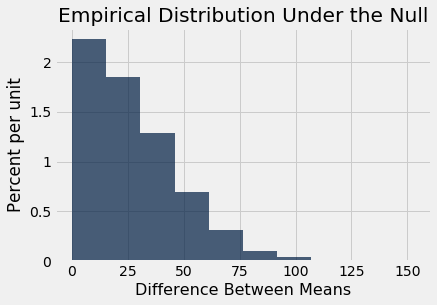

In [9]:
t = quarterly_data_rec.select("In Recession", "OUTPUT MINUS POTENTIAL")
observed = abs(difference_in_means(t))
stats = make_array()
means_diffs = make_array()
for i in np.arange(10000):
    shuffled_var = t.select("OUTPUT MINUS POTENTIAL").sample(with_replacement=False).column(0)
    shuffled = t.select("In Recession").with_column('Shuffled Variable', shuffled_var)
    new_stat = abs(difference_in_means(shuffled))
    stats = np.append(stats, new_stat)

p = np.count_nonzero(stats >= observed) / 10000

Table().with_column('Difference Between Means', stats).hist()
plots.title('Empirical Distribution Under the Null')
print('Average difference between actual and potential output at recession vs not:', observed)
print('Empirical P-value:', p)

The p-value is far less than the determined significance level of 5%; therefore we will **reject the null** that  whether the economy is in a recession and output level relative to potential output are independent of each other.

Approximate 95% CI for the difference between means:
27.2543300763 to 164.553352339


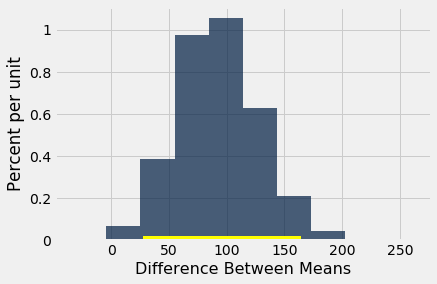

In [10]:
"""Bootstrap approximate 95% confidence interval
for the difference between the means of the two 
classes in the population"""
    
stats = make_array()
for i in np.arange(10000):
    bootstrap_sample = t.sample()
    new_stat = difference_in_means(bootstrap_sample)
    stats = np.append(stats, new_stat)
        
left = percentile(2.5, stats)
right = percentile(97.5, stats)
    
Table().with_column('Difference Between Means', stats).hist()
plots.plot(make_array(left, right), make_array(0, 0), color='yellow', lw=8)
print('Approximate 95% CI for the difference between means:')
print(left, 'to', right)

## The Fed's Reaction Function

We know that the Federal Reserve tends to adjust the real interest rate according to the inflation rate as a part of countercyclical monetary policy. When output is below potential, the inflation rate falls because firms are operating below their level of comfort, so they must lower prices. To counteract this, the Fed will engage in open market operations to bring output back to potential. By selling government bonds, it can increase the money supply and lower interest rates. Therefore, people will consume more as will firms invest more, bringing output back to potential. The Fed can set a target inflation rate by defining how they change the real interest rate in response to changes in inflation; this is called the *reaction function*. 

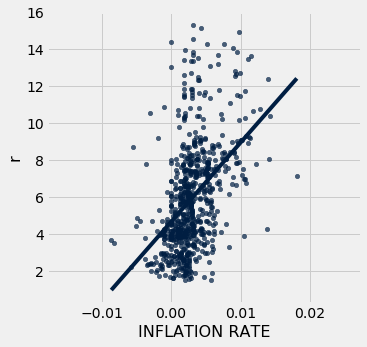

In [11]:
fed_reaction_function = inflation_by_month.join("DATE", r)
fed_reaction_function.scatter("INFLATION RATE", "r", fit_line = True)

In [12]:
def standard_units(any_numbers):
    "Convert any array of numbers to standard units."
    return (any_numbers - np.mean(any_numbers)) / np.std(any_numbers)  

def standardize(t):
    """Return a table in which all columns of t are converted to standard units."""
    t_su = Table()
    for label in t.labels:
        t_su = t_su.with_column(label + ' (su)', standard_units(t.column(label)))
    return t_su

def correlation(t, x, y):
    """Return the correlation coefficient (r) of two variables."""
    return np.mean(standard_units(t.column(x)) * standard_units(t.column(y)))

In [13]:
def slope(t, x, y):
    """The slope of ther regression line (original units)."""
    r = correlation(t, x, y)
    return r * np.std(t.column(y)) / np.std(t.column(x))

def intercept(t, x, y):
    """The intercept of the regression line (original units)."""
    return np.mean(t.column(y)) - slope(t, x, y) * np.mean(t.column(x))

DRAW THE RESIDUAL PLOT AND EVALUATE HOW APPROPRIATE IT WAS TO USE REGRESSION

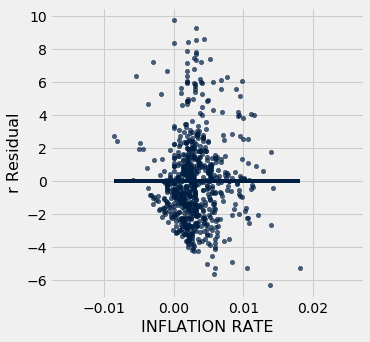

In [14]:
line_slope = slope(fed_reaction_function, "INFLATION RATE", "r")
line_intercept = intercept(fed_reaction_function, "INFLATION RATE", "r")
estimates = fed_reaction_function.column("INFLATION RATE")*line_slope + line_intercept
fed_react_resid = Table().with_columns("INFLATION RATE", fed_reaction_function.column("INFLATION RATE"), "r Residual", fed_reaction_function.column("r") - estimates )
fed_react_resid.scatter("INFLATION RATE", fit_line = True)


From the residual plot, it is clear that Linear Least-Squares Regression is not a very applicable form of estimation.


In [15]:
correlation(fed_reaction_function, "INFLATION RATE", "r")

0.46141756527147193

In [16]:
inflation = fed_reaction_function.column("INFLATION RATE")
real_interest = fed_reaction_function.column("r")
pol = np.poly1d(np.polyfit(inflation, real_interest, deg = 2 ))

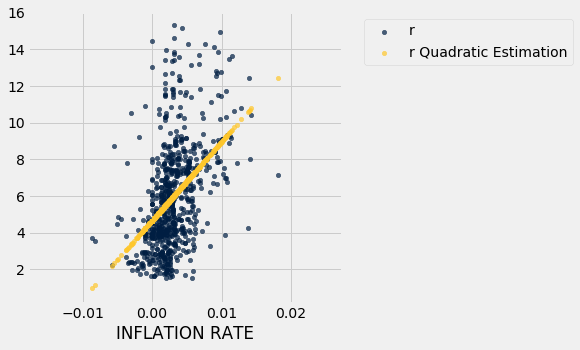

In [17]:
quad_fed_react = fed_reaction_function.select("INFLATION RATE", "r").with_column("r Quadratic Estimation", pol(fed_reaction_function.column("INFLATION RATE")))
quad_fed_react.scatter("INFLATION RATE", overlay = True)

In [ ]:
train_prices = train.column(0)
train_attributes = train.drop(0)

def rmse(slopes, attributes, prices):
    errors = []
    for i in np.arange(len(prices)):
        predicted = predict(slopes, attributes.row(i))
        actual = prices.item(i)
        errors.append((predicted - actual) ** 2)
    return np.mean(errors) ** 0.5

def rmse_train(slopes):
    return rmse(slopes, train_attributes, train_prices)

print('RMSE of all training examples using random slopes:', rmse_train(example_slopes))

Ok, so clearly Quadratic Least Squares is not a good fit either. After trying higher degree polynomials, it is clear that any polynomial Least Squares prediction will not work.

predict the output - potential output for a quarter given the output-potential, inflation rate, and unemployment rate of the previous 40 quarters.
Input vector shape => [?, 120]
Output vector shape => [?, 1]

In [21]:
import tensorflow as tf

In [102]:
num_features = 120
num_out = 1
num_it = 30
quarterly_data

DATE,GDP,POTENTIAL GDP,UNEMPLOYMENT RATE,INFLATION RATE,OUTPUT MINUS POTENTIAL
1949-01,2007.5,2011.3,4.3,-0.00108591,-3.8
1949-04,2000.8,2038.1,5.3,-0.00836225,-37.3
1949-07,2022.8,2065.2,6.7,-0.00240334,-42.4
1949-10,2004.7,2092.6,7.9,-0.00308538,-87.9
1950-01,2084.6,2120.1,6.5,0.00763132,-35.5
1950-04,2147.6,2147.2,5.8,0.0183448,0.4
1950-07,2230.4,2174.7,5,0.0202454,55.7
1950-10,2273.4,2202.5,4.2,0.0406593,70.9
1951-01,2304.5,2230.8,3.7,0.00972876,73.7
1951-04,2344.5,2260.7,3.1,-0.000539561,83.8


In [51]:
ind = 40
trainX = np.array(np.zeros(120))
trainY = np.array(np.zeros(1))
allX = np.array(np.zeros(120))
allY = np.array(np.zeros(1))
while (ind < quarterly_data.num_rows):
    temp = np.array([])
    for i in range(ind-40, ind):
        row = np.array(quarterly_data.row(i))
        temp = np.append(temp, [float(row[3]), float(row[4]), float(row[5])])
    allX = np.vstack((allX, np.array(temp)))
    allY = np.vstack((allY, np.array(np.array(float(np.array(quarterly_data.row(ind))[5])))))
    if(ind < quarterly_data.num_rows-(4*20)):
        trainX = np.vstack((trainX, np.array(temp)))
        trainY = np.vstack((trainY, np.array(np.array(float(np.array(quarterly_data.row(ind))[5])))))
    ind+=1
trainX = trainX[1:,:]
trainY = trainY[1:, :]


In [78]:
x = tf.placeholder(tf.float32, [None, num_features])

keep_prob = tf.placeholder(tf.float32)
drop1 = tf.nn.dropout(x, keep_prob)

W1 = tf.Variable(tf.truncated_normal([num_features, 50],
                                    stddev=1./math.sqrt(num_features)))
b1 = tf.Variable(tf.zeros([50]))
y1 = tf.nn.relu(tf.matmul(x, W1) + b1)

drop2 = tf.nn.dropout(y1, keep_prob)

W2 = tf.Variable(tf.truncated_normal([50, num_out],
                                    stddev=1./math.sqrt(num_features)))
b2 = tf.Variable(tf.zeros([num_out]))
y2 = tf.matmul(y1, W2) + b2

y_ = tf.placeholder(tf.float32, [None, num_out])

cost = np.abs(y2-y_)
train_step = tf.train.AdamOptimizer(5e-3).minimize(cost)

In [103]:
sess = tf.InteractiveSession()

saver = tf.train.Saver()
correct_prediction = y2-y_
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
tf.global_variables_initializer().run()
saver = tf.train.Saver()

count = 0
max_train_acc = .926206
max_test_acc = .980658
test_acc = .5
train_acc = .5
while count < num_it:
    try:
        feed_dict = {x: trainX, y_: trainY, keep_prob: 0.5}
        example_data, train_acc = sess.run([train_step, accuracy], feed_dict)
    except tf.errors.OutOfRangeError:
        break
        
    print('training session', count,'\t|training accuracy', train_acc)
    count+=1

training session 0 	|training accuracy 7.58305
training session 1 	|training accuracy -1.10027
training session 2 	|training accuracy -5.70193
training session 3 	|training accuracy -6.92644
training session 4 	|training accuracy -8.16986
training session 5 	|training accuracy -8.63794
training session 6 	|training accuracy -7.73307
training session 7 	|training accuracy -6.34191
training session 8 	|training accuracy -2.71647
training session 9 	|training accuracy -0.552018
training session 10 	|training accuracy -1.43108
training session 11 	|training accuracy -4.08231
training session 12 	|training accuracy -2.49357
training session 13 	|training accuracy 0.375633
training session 14 	|training accuracy 2.77227
training session 15 	|training accuracy 2.27582
training session 16 	|training accuracy 2.31554
training session 17 	|training accuracy 3.03323
training session 18 	|training accuracy 3.9592
training session 19 	|training accuracy 5.11646
training session 20 	|training accura

In [104]:
predictions = y2
eval_predictions = predictions.eval(feed_dict={x: allX, keep_prob: 1.}, session=sess)

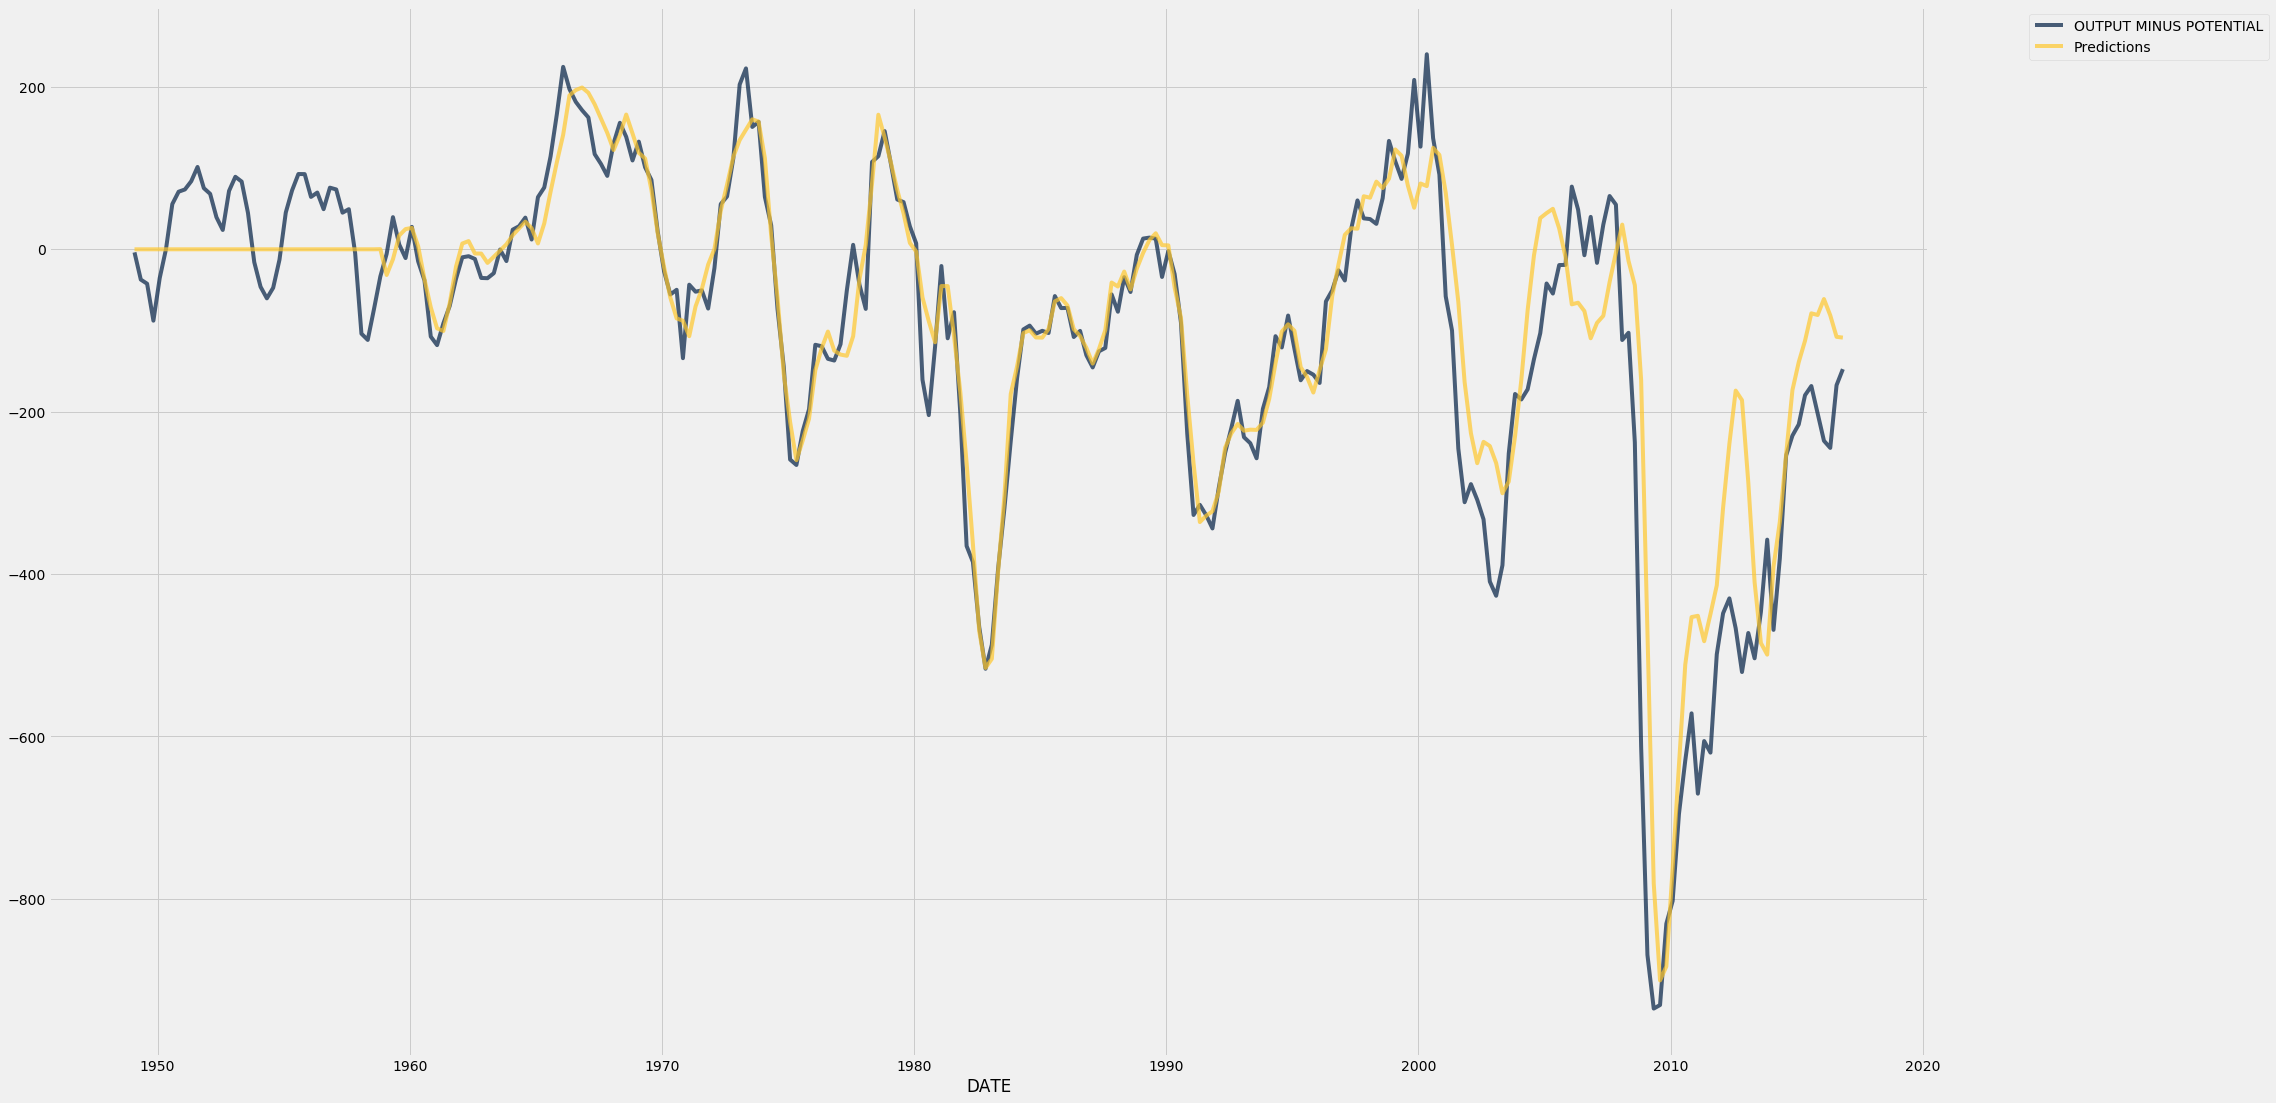

In [105]:
quarterly_data_pred = quarterly_data.with_column("Predictions", np.append(np.zeros(39), eval_predictions))

quarterly_pred_w_time = quarterly_data_pred.select("OUTPUT MINUS POTENTIAL", "Predictions").with_column("DATE", [int(x[:len(x) - 3]) + int(x[len(x) - 2:])/12 for x in quarterly_data.column("DATE")])
quarterly_pred_w_time.plot("DATE", width = 30, height = 18)

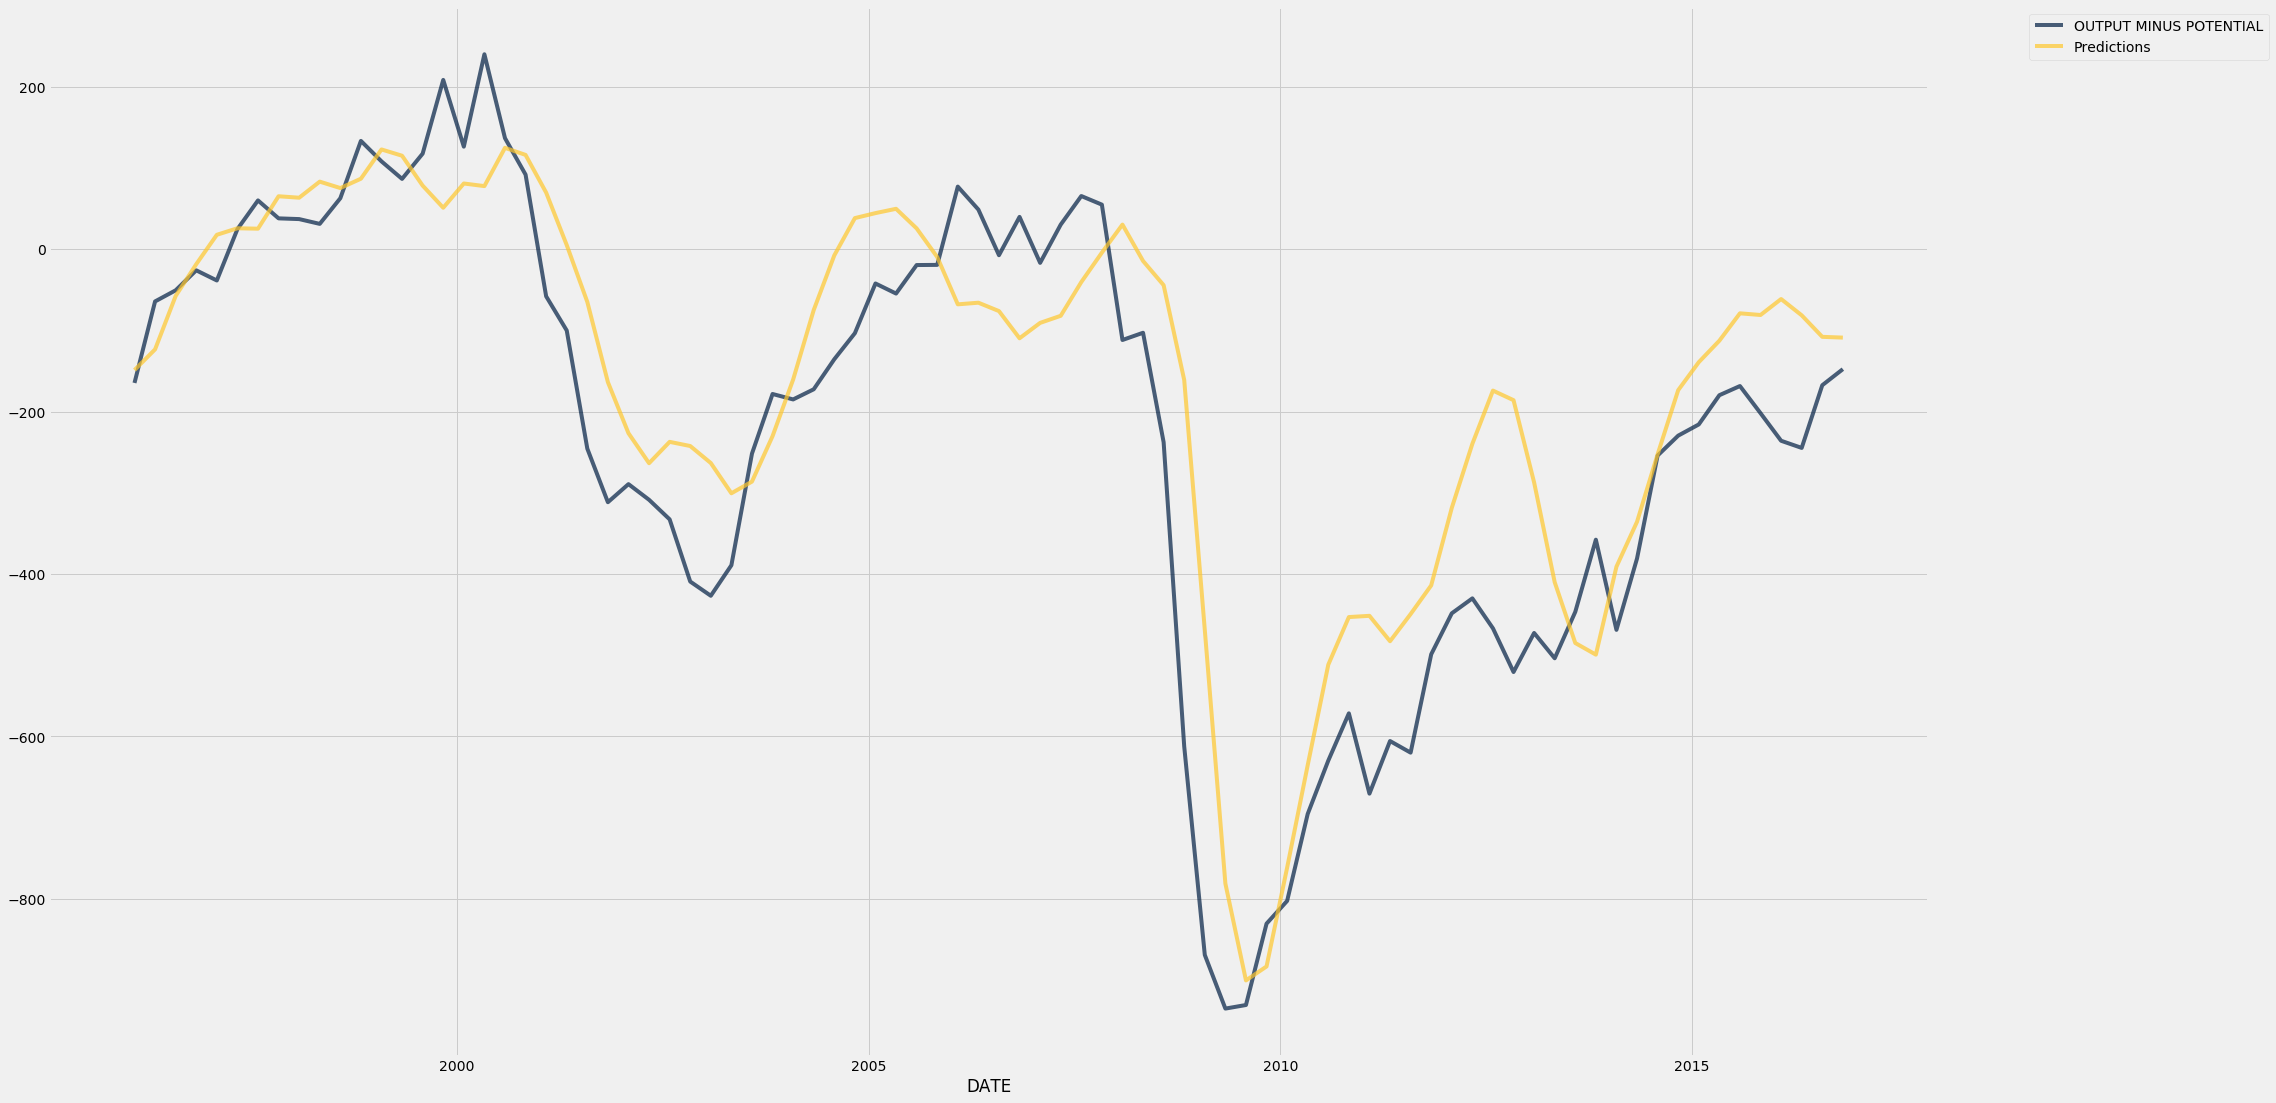

In [108]:
quarterly_pred_w_time.where("DATE", are.between(1996, 2018)).plot("DATE", width = 30, height = 18)

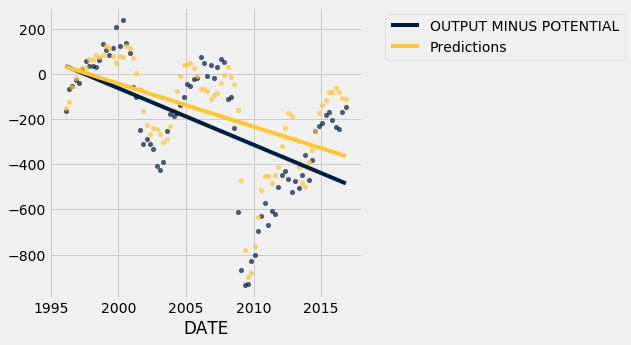

In [112]:
quarterly_pred_w_time.where("DATE", are.between(1996, 2018)).scatter("DATE", fit_line = True, )

array([[-18.34167862]], dtype=float32)